# Tire Quality Classification with Deep Learning

![Ejemplo de imagen](https://www.thermaxglobal.com/wp-content/uploads/2020/02/TYRE.jpg)

## Introduction

Quality control plays a critical role in industrial manufacturing, ensuring the reliability, safety, and longevity of products. In industries such as tire manufacturing, where product quality directly impacts road safety, effective defect detection during production is essential. Traditional quality control methods often rely on manual inspection, which can be time-consuming, subjective, and prone to human error. The rise of artificial intelligence and machine learning technologies has introduced new opportunities for automating and enhancing these processes. By applying techniques such as neural networks for image analysis, it is now possible to perform fast and accurate inspections, improving both efficiency and cost-effectiveness. This project focuses on developing a neural network-based classification model for detecting defective tires, contributing to the advancement of quality control in the automotive industry.

## Objective

The objective of this project is to evaluate and optimize neural network models for the classification of defective vs. non-defective tires, aiming to achieve high accuracy and robust performance in automated quality control applications.

## Importing Libraries and Dataset

We begin by importing the necessary libraries for data handling, visualization, and evaluation.

In [ ]:
import pandas as pd
import os
import numpy as np
import random

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score,ConfusionMatrixDisplay,classification_report

import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models

Importing the dataset from Kaggle.com

In [ ]:
!pip install opendatasets

In [ ]:
import opendatasets as od
od.download("https://www.kaggle.com/datasets/warcoder/tyre-quality-classification")

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: mariofreites
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/warcoder/tyre-quality-classification


100%|██████████| 2.66G/2.66G [00:31<00:00, 89.5MB/s]


## Data Exploration

In this section, we visualize sample images from both classes and create a bar plot to assess the class distribution and check for potential class imbalance.

In [ ]:
defective_images="/content/tyre-quality-classification/Digital images of defective and good condition tyres/defective"
good_images="/content/tyre-quality-classification/Digital images of defective and good condition tyres/good"

In [ ]:
# Dataset size
defective_files = os.listdir(defective_images)
defective_files = len(defective_files)

good_files = os.listdir(good_images)
good_files = len(good_files)

total_files = defective_files + good_files

perc_defective = round(defective_files / total_files * 100 , 2)
perc_good = round(good_files / total_files * 100 , 2)


print(f"Total number of images: {total_files}")
print(f"Defective Tyres images: {defective_files} ({perc_defective}% of total)")
print(f"Good Tyres images: {good_files} ({perc_good}% of total)")

Total number of images: 1856
Defective Tyres images: 1028 (55.39% of total)
Good Tyres images: 828 (44.61% of total)


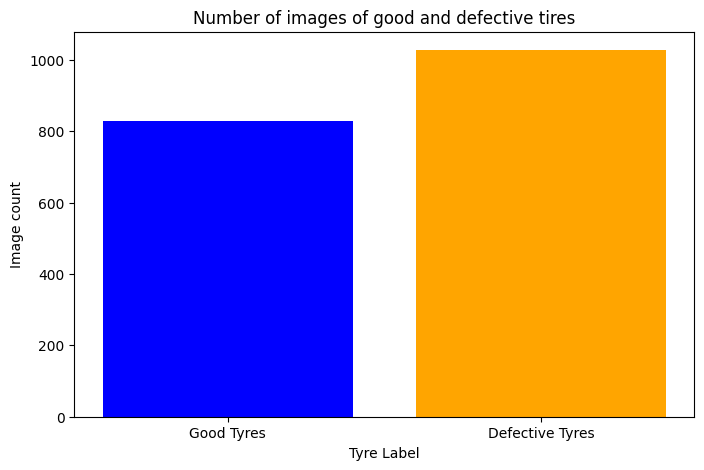

In [ ]:
categories = ['Good Tyres', 'Defective Tyres']
values = [good_files, defective_files]

plt.figure(figsize=(8, 5))
plt.bar(categories, values, color=['blue', 'orange'])
plt.xlabel('Tyre Label')
plt.ylabel('Image count')
plt.title('Number of images of good and defective tires')
plt.show()

The dataset is balanced.

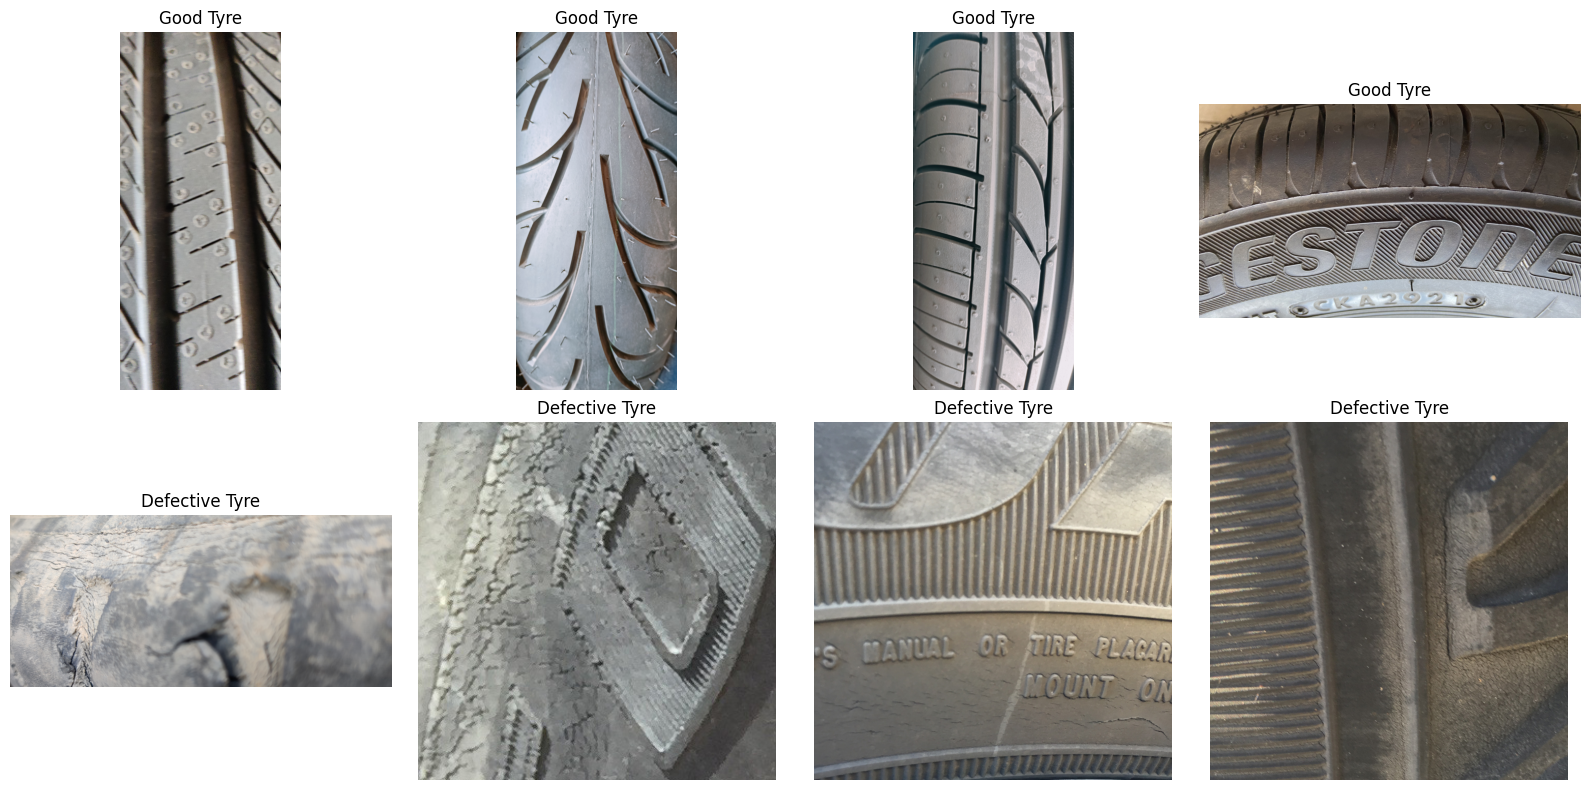

In [ ]:
# Pick 4 random images from each folder
good_images_list = random.sample(os.listdir(good_images), 4)
defective_images_list = random.sample(os.listdir(defective_images), 4)

# Create a 2x4 plot
fig, axes = plt.subplots(2, 4, figsize=(16, 8))

# Show images in a grid
for i in range(4):
    # "Good Tyres" row
    img_good = mpimg.imread(os.path.join(good_images, good_images_list[i]))
    axes[0, i].imshow(img_good)
    axes[0, i].axis('off')
    axes[0, i].set_title("Good Tyre")

    # "Defective Tyres" row
    img_defective = mpimg.imread(os.path.join(defective_images, defective_images_list[i]))
    axes[1, i].imshow(img_defective)
    axes[1, i].axis('off')
    axes[1, i].set_title("Defective Tyre")

# Show the plot
plt.tight_layout()
plt.show()

## Model Building and Training

In this section, we build and train a Convolutional Neural Network (CNN) model for classifying tire images as either defective or non-defective. The process involves loading the dataset, applying data augmentation techniques to improve model generalization, and building the CNN architecture. Finally, the model is compiled, trained, and evaluated using training and validation data.

The dataset is loaded using the image_dataset_from_directory function. We split the dataset into training and validation sets (80/20 split) and resize the images to 224x224 pixels. We also set the batch size to 32 for training.

In [ ]:
# Define the dataset path
image_directory = "/content/tyre-quality-classification/Digital images of defective and good condition tyres"

# Load data with training and validation division
batch_size = 32
img_height = 224
img_width = 224

train_ds = image_dataset_from_directory(
    image_directory,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size)

val_ds = image_dataset_from_directory(
    image_directory,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size)

Found 1856 files belonging to 2 classes.
Using 1485 files for training.
Found 1856 files belonging to 2 classes.
Using 371 files for validation.


Data augmentation techniques are applied here to artificially increase the size and diversity of the training dataset. This includes random rotations, shifts, zooms, and flips of the images to help the model generalize better.

In [ ]:
# Data Augmentation

datagen = ImageDataGenerator(
    rescale=1.0/255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

A Convolutional Neural Network (CNN) is built with four convolutional layers followed by max-pooling layers. The model ends with a fully connected layer with a sigmoid activation function, making it suitable for binary classification (defective vs. non-defective).

The model is compiled using the Adam optimizer, binary cross-entropy loss function (appropriate for binary classification), and accuracy as the evaluation metric.

In [ ]:
# Building the CNN model
model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(img_height, img_width, 3)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    #layers.Dense(512, activation='relu'),
    layers.Dense(1, activation='sigmoid')  # Sigmoid activation for binary classification
])

# Compile the model
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Summarize the model
model.summary()


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 222, 222, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 111, 111, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 109, 109, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 54, 54, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 52, 52, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 26, 26, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 24, 24, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 12, 12, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 18432)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │          18,433 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 259,265 (1012.75 KB)

 Trainable params: 259,265 (1012.75 KB)

 Non-trainable params: 0 (0.00 B)

The model is trained for 10 epochs using the training and validation datasets. The training progress is saved in the history object.

In [ ]:
epochs = 10
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs
)


Epoch 1/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 267s 6s/step - accuracy: 0.5473 - loss: 14.7724 - val_accuracy: 0.6604 - val_loss: 0.5806
Epoch 2/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 336s 6s/step - accuracy: 0.6846 - loss: 0.5661 - val_accuracy: 0.7062 - val_loss: 0.5498
Epoch 3/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 305s 6s/step - accuracy: 0.6297 - loss: 0.6486 - val_accuracy: 0.6523 - val_loss: 0.6376
Epoch 4/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 266s 6s/step - accuracy: 0.6679 - loss: 0.6052 - val_accuracy: 0.7358 - val_loss: 0.5557
Epoch 5/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 262s 6s/step - accuracy: 0.7151 - loss: 0.5383 - val_accuracy: 0.6712 - val_loss: 0.5918
Epoch 6/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 278s 6s/step - accuracy: 0.7300 - loss: 0.5176 - val_accuracy: 0.7008 - val_loss: 0.5786
Epoch 7/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 306s 5s/step - accuracy: 0.7415 - loss: 0.5045 - val_accuracy: 0.7305 - val_loss: 0.5634
Epoch 8/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 320s 5s/step - accuracy: 0.7885 - loss: 0.4485 - val_accuracy: 0.7412 - 

After training, we visualize the accuracy and loss curves for both training and validation sets across the epochs. This helps assess model performance and detect overfitting or underfitting.

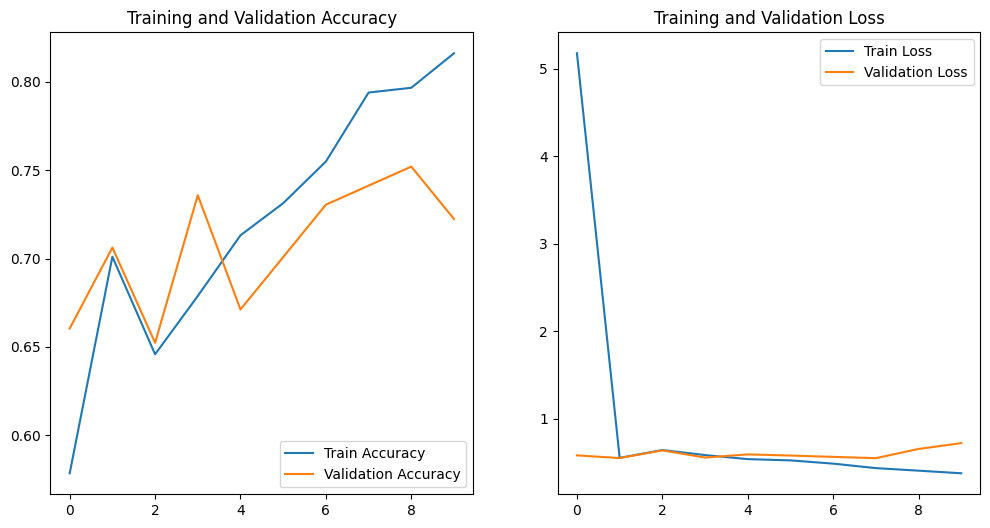

In [ ]:
# Graph accuracy and loss
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Train Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Train Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()


**Discussion:**

The model achieves 80.61% training accuracy but only 68.73% validation accuracy, indicating potential overfitting. Training loss is 0.4207, while validation loss is higher at 0.6159, further suggesting that the model is not generalizing well to unseen data. Although data augmentation techniques, such as rotation, shifting, and flipping, were applied to mitigate this issue, the model still struggles to perform consistently on the validation set.

To address the overfitting problem and enhance generalization, the next step will be to implement transfer learning with a pre-trained ResNet50 model. By leveraging features learned from large-scale datasets, this approach should help the model better generalize to new, unseen data and improve validation accuracy.


## Transfer Learning

To address the overfitting observed in the initial model, we turn to transfer learning with the pre-trained ResNet50 model. ResNet50, trained on the large ImageNet dataset, offers powerful feature extraction capabilities. By freezing its layers and adding custom layers on top, we can fine-tune the model for tire classification, leveraging its pre-learned features to improve generalization and boost validation accuracy.

In [ ]:
from tensorflow.keras.applications import ResNet50

# Load pretrained ResNet50 model
base_model = ResNet50(input_shape=(img_height, img_width, 3),
                      include_top=False,
                      weights='imagenet')

# Freeze the base model layers
base_model.trainable = False

# Create the model
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),  # Aplana las características
    layers.Dropout(0.5),              # Dropout para reducir sobreajuste
    layers.Dense(256, activation='relu'),  # Capa densa adicional
    layers.Dense(1, activation='sigmoid')  # Capa de salida para clasificación binaria
])

# Compile the model
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [16]:
# Train the model
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10
)


Epoch 1/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 495s 10s/step - accuracy: 0.7713 - loss: 0.6466 - val_accuracy: 0.9191 - val_loss: 0.1913
Epoch 2/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 497s 10s/step - accuracy: 0.9184 - loss: 0.1889 - val_accuracy: 0.9299 - val_loss: 0.1616
Epoch 3/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 443s 9s/step - accuracy: 0.9231 - loss: 0.1746 - val_accuracy: 0.9488 - val_loss: 0.1366
Epoch 4/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 483s 10s/step - accuracy: 0.9512 - loss: 0.1223 - val_accuracy: 0.9488 - val_loss: 0.1220
Epoch 5/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 439s 9s/step - accuracy: 0.9446 - loss: 0.1482 - val_accuracy: 0.9434 - val_loss: 0.1315
Epoch 6/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 421s 9s/step - accuracy: 0.9619 - loss: 0.0962 - val_accuracy: 0.9542 - val_loss: 0.1216
Epoch 7/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 442s 9s/step - accuracy: 0.9575 - loss: 0.1084 - val_accuracy: 0.9326 - val_loss: 0.1714
Epoch 8/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 444s 9s/step - accuracy: 0.9746 - loss: 0.0719 - val_accuracy: 0.9542 

In [18]:
# Evaluating the model on validation data
val_loss, val_accuracy = model.evaluate(val_ds)
print(f"Validation Accuracy: {val_accuracy:.2f}")
print(f"Validation Loss: {val_loss:.2f}")


12/12 ━━━━━━━━━━━━━━━━━━━━ 84s 7s/step - accuracy: 0.9343 - loss: 0.1864
Validation Accuracy: 0.93
Validation Loss: 0.18


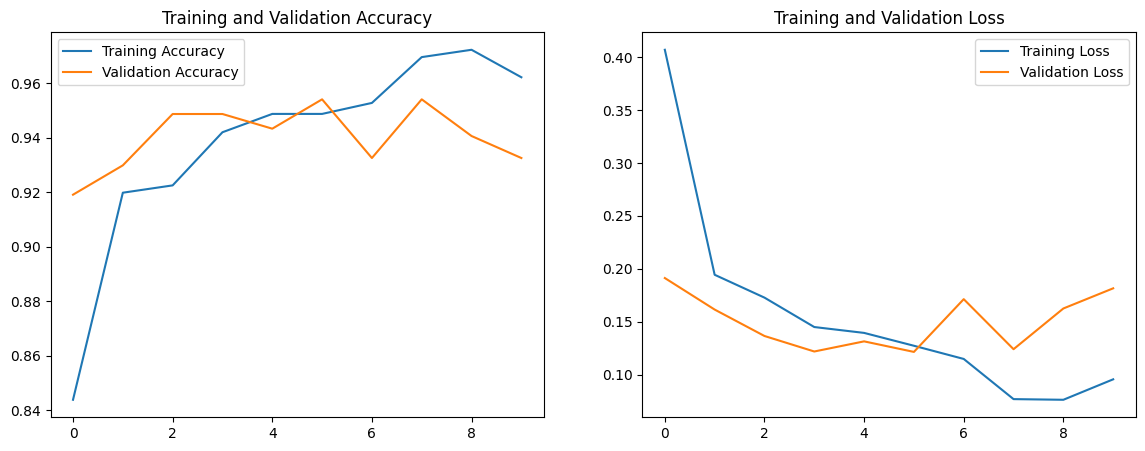

In [19]:
# Graphing accuracy and loss
plt.figure(figsize=(14, 5))

# Graphing accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

# Graphing loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.show()


The model achieves high validation accuracy (93%) and low validation loss (0.18), indicating strong generalization and confidence in its predictions. This suggests the model effectively distinguishes between good and defective tires.

## Making Predictions

In this section, we evaluate the model’s performance on the validation dataset by comparing the actual and predicted labels for a subset of images. We also calculate the confusion matrix and key metrics, including precision, recall, F1-score, and accuracy, to assess the model's classification performance.

First, we extract images and labels from the validation dataset into x_val and y_val lists, respectively.

In [27]:
x_val=[]
y_val=[]


for image, label in val_ds:
    x_val.extend(image.numpy())
    y_val.extend(label.numpy())

The model is used to predict labels for x_val, and the predictions are rounded to binary values (0 or 1) to match the label format.

In [28]:
predictions=model.predict(np.array(x_val))

y_pred=[int(np.round(prediction)) for prediction in predictions]

12/12 ━━━━━━━━━━━━━━━━━━━━ 75s 6s/step


<ipython-input-28-1cce3c47f467>:4: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred=[int(np.round(prediction)) for prediction in predictions]


We display a 6x4 grid of images with each image’s actual and predicted labels, color-coded in green for correct predictions and red for incorrect ones.

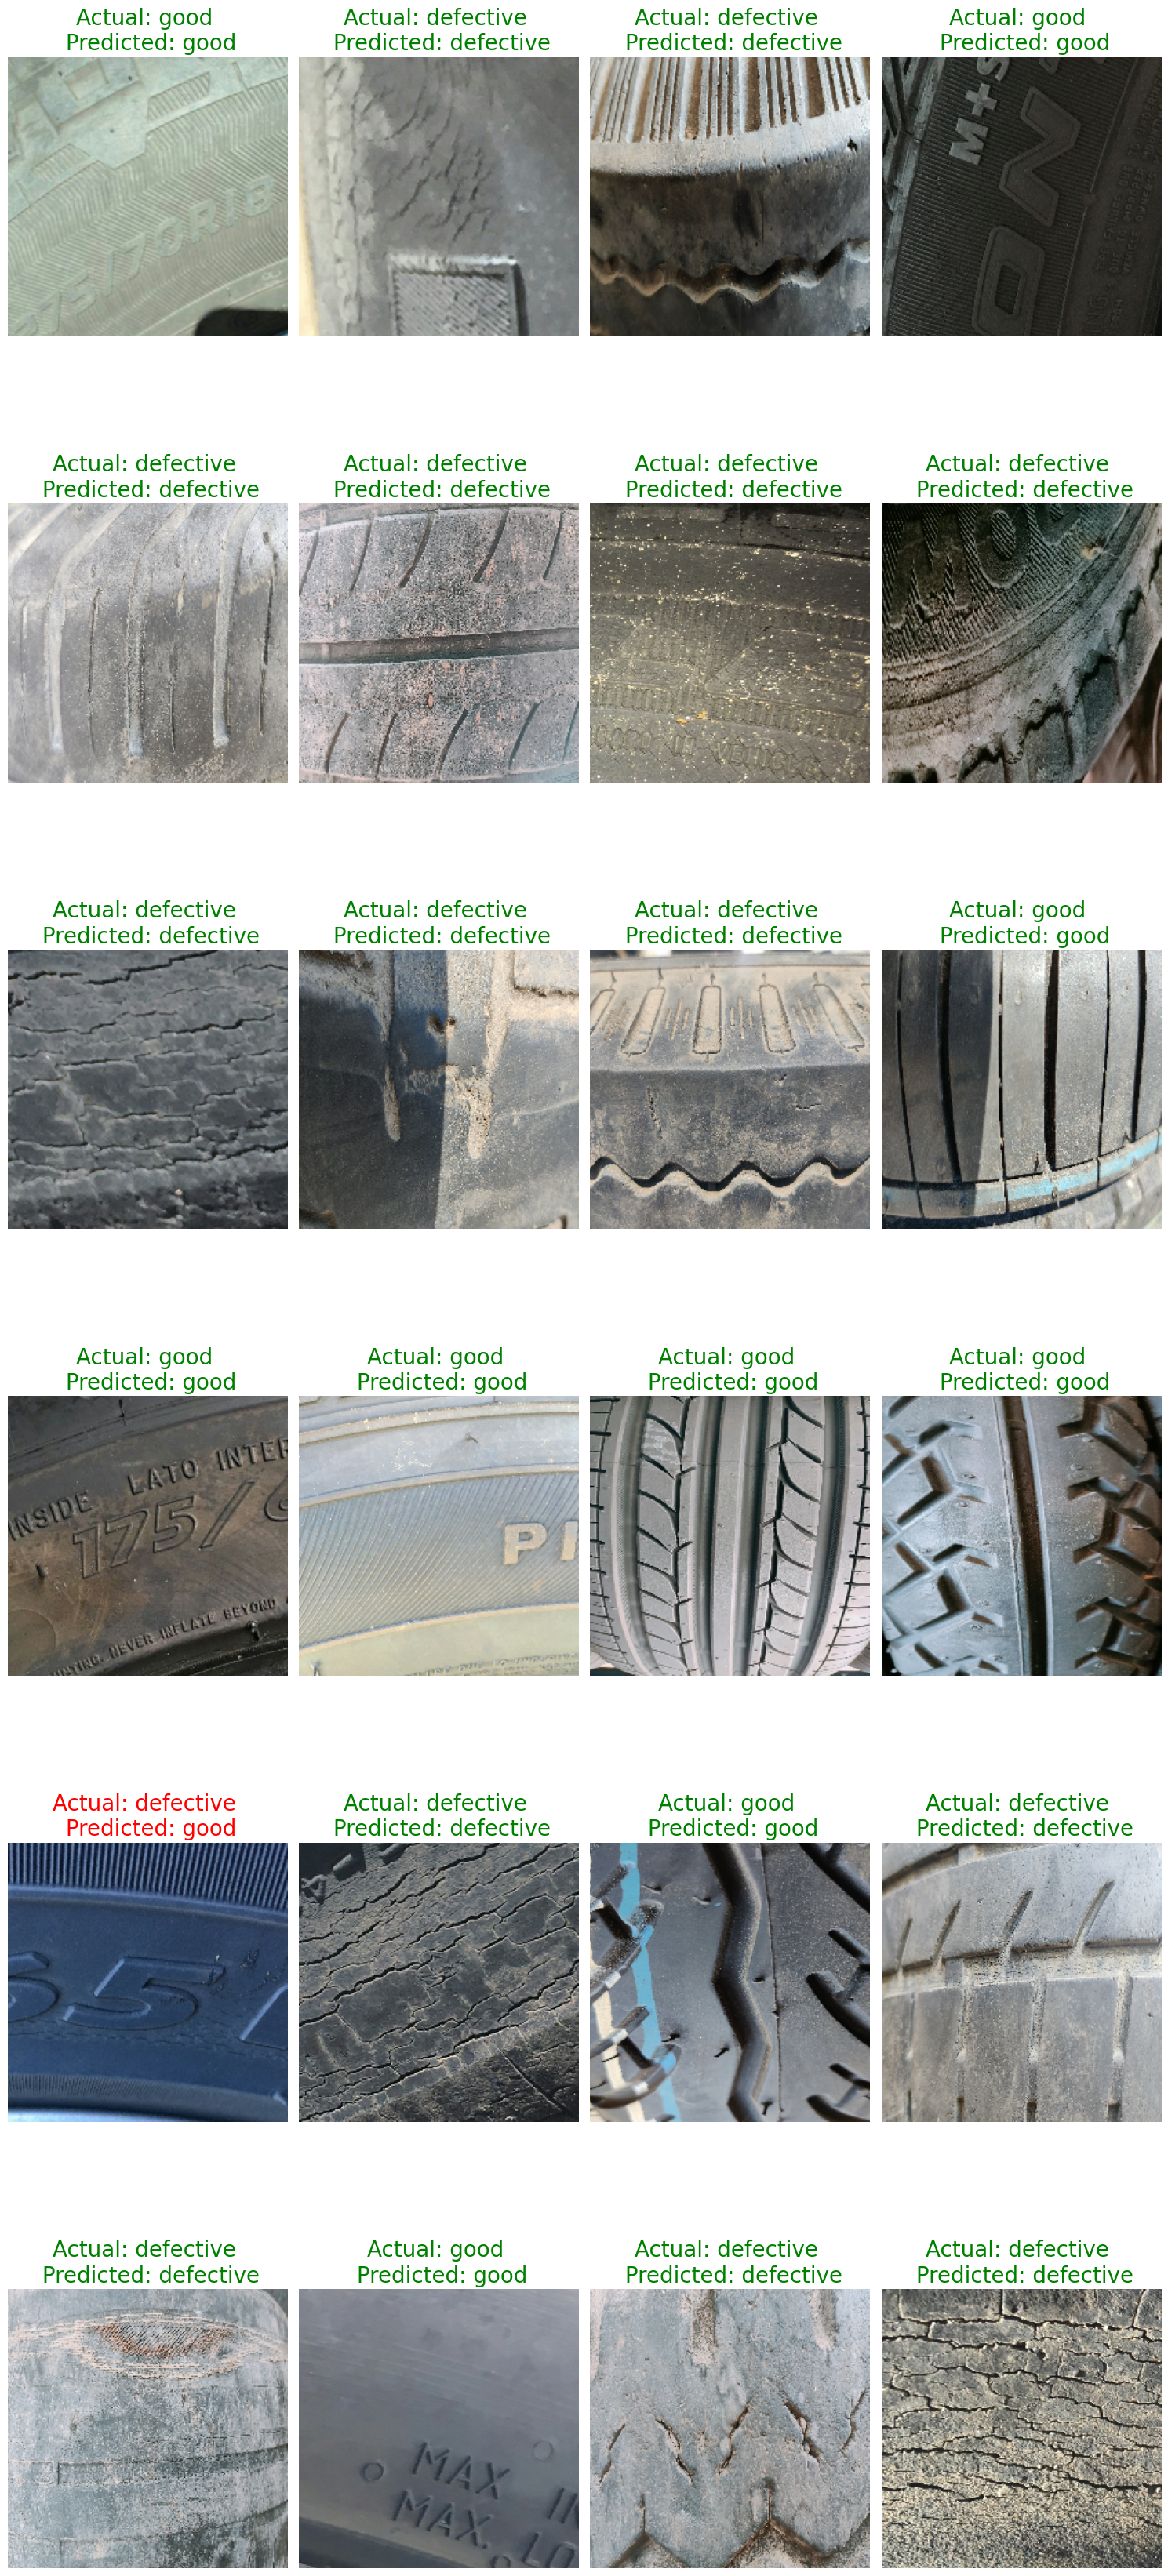

In [35]:
plt.figure(figsize=(15, 35),tight_layout=True, facecolor="white")


for i in range(24):
    ax = plt.subplot(6, 4, i + 1)
    plt.imshow(x_val[i].astype("uint8"))
    actual_label = class_names[y_val[i]]
    predicted_label = class_names[y_pred[i]]

    # Check if the actual and predicted labels are the same
    if actual_label == predicted_label:
        label_color ='green'
    else:
        label_color = 'red'


    plt.title(f'Actual: {actual_label} \n Predicted: {predicted_label}', color=label_color,fontsize=20)
    plt.axis("off")

plt.show()

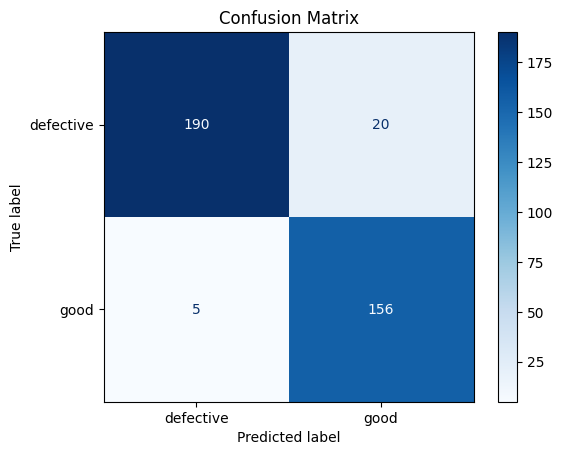

In [36]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Genera la matriz de confusión
cm = confusion_matrix(y_val, y_pred)

# Visualiza la matriz de confusión
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap='Blues', values_format='d')
plt.title("Confusion Matrix")
plt.show()

The confusion matrix results indicates the model is correctly identifying most instances, with a low false positive rate but a higher false negative rate. The model performs well, but reducing false negatives (defective tires missed) would be crucial for better safety outcomes.

In [44]:
# Get the classification report
report = classification_report(y_val, y_pred, output_dict=True)

# Convert the report to a DataFrame for better visualization
report_df = pd.DataFrame(report).transpose()

# Display the DataFrame with a background gradient for visual appeal
report_df.style.background_gradient(cmap='Blues')

## Conclusion

The model shows strong performance with high accuracy and a well-balanced precision and recall, effectively distinguishing between good and defective tires. the ResNet50 architecture significantly outperformed those achieved with the custom CNN, showing that pre-trained models can provide better performance in this particular task.

There is room for improvement in reducing false negatives (defective tires misclassified as good). Although the model accurately identifies good tires, the higher false negative rate could be a concern for safety in real-world applications.

Next Steps:
To improve the model before deployment, efforts should focus on reducing false negatives by adjusting the decision threshold or exploring different architectures. Additionally, hyperparameter tuning and cross-validation could further enhance performance. Testing the model with real-world data will also ensure its robustness across various conditions before production deployment.